In [36]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm
from sklearn.cluster import KMeans
from factor_analyzer import FactorAnalyzer


In [37]:
start = '2017-01-01'
end = '2021-12-31'
data = pd.read_csv("../Factor_Alpha_2017_2021.csv", index_col=[0])
stock_list = list(data.index)[:15]

df_close = yf.download(stock_list, start=start, end=end, progress=False)['Adj Close']
df_close.to_csv("temp_top15_2017.csv")
spx_close = yf.download("^GSPC", start=start, end=end, progress=False)['Adj Close']

In [38]:
df_close_pct = df_close.pct_change()
spx_pct = spx_close.pct_change()

df_close_pct.dropna(inplace=True)
spx_pct.dropna(inplace=True)

df_close_pct_m = df_close_pct.resample("ME").agg(lambda x: (x+1).prod() - 1)
spx_pct_m = spx_pct.resample("ME").agg(lambda x: (x+1).prod() - 1)

In [100]:
factor = 3
res_df = pd.DataFrame()
alpha_dict = {}
X = spx_pct_m
X_sm = sm.add_constant(X)
for ticker in df_close.columns:
    # OLS regression
    close = df_close_pct_m[ticker]
    y = close

    model = sm.OLS(y, X_sm)
    res = model.fit()
    residuals = res.resid
    res_df[ticker] = residuals

    # store alpha
    res_table = res.summary().tables
    alpha = float(res_table[1].data[1][1].strip())
    alpha_dict[ticker] = alpha
factor_analyzer = FactorAnalyzer(n_factors=factor, rotation='promax') # varimax
factor_analyzer.fit(res_df.corr())

# Get factor loadings
factor_loadings = factor_analyzer.loadings_
df = pd.DataFrame(factor_loadings, index=list(res_df.columns))
df['Ticker'] = df.index
# Apply K-means clustering
kmeans = KMeans(n_clusters=factor)
kmeans.fit(df.iloc[:, :factor])

# Assign cluster labels to tickers
df['Cluster'] = kmeans.labels_

# Display the result
res = df[['Ticker', 'Cluster']]
res = res.copy()
# add clustered value to check further
cluster_value = []
for i in range(len(res)):
    classification = res.iloc[i, 1]
    cluster_value.append(df.iloc[i, classification])
res['Cluster_value'] = cluster_value

sorted_res = res.sort_values(by='Cluster')


res_dict = {}
for i in range(factor):

    res_dict[str(i)] = list(sorted_res[sorted_res['Cluster'] == i]['Ticker'])
res_dict
# factor == 3比較穩定 但還是不合理

{'0': ['AXON', 'DXCM', 'ENPH', 'EPAM', 'FTNT', 'MTCH', 'PODD'],
 '1': ['AMAT', 'LRCX', 'ON'],
 '2': ['DECK', 'ETSY', 'GNRC', 'RMD', 'TSLA']}

In [136]:
# classification index
import numpy as np
indexes = pd.DataFrame()
for key, value in res_dict.items():
    print(value)
    index_close = df_close[value]
    index_close = index_close/len(value)
    indexes[f"{str(key)}-index"] = index_close.sum(axis=1)

indexes_pct = indexes.pct_change()
indexes_pct.dropna(inplace=True)

indexes_pct_m = indexes_pct.resample("ME").agg(lambda x: (x+1).prod() - 1)
mean = np.mean(indexes_pct_m, axis=0)
sd = np.std(indexes_pct_m, axis=0)
reg_coef = []
for i in range(len(indexes_pct_m.columns)):
    X = spx_pct_m
    X_sm = sm.add_constant(X)
    y = indexes_pct_m.iloc[:, i]
    model = sm.OLS(y, X_sm)
    res = model.fit()
    reg_coef.append(res.summary().tables[1].data[2][1])


result = pd.DataFrame()
result.index = list(indexes.columns)
result["mean"] = mean
result["sd"] = sd
result["reg_coef"] = reg_coef


['AXON', 'DXCM', 'ENPH', 'EPAM', 'FTNT', 'MTCH', 'PODD']
['AMAT', 'LRCX', 'ON']
['DECK', 'ETSY', 'GNRC', 'RMD', 'TSLA']


In [137]:
# result 1: growth 2:stable 0: cyclical

,mean,sd,reg_coef
0-index,0.041507,0.072329,0.9708
1-index,0.036685,0.097067,1.2297
2-index,0.038685,0.069607,0.9258


[*********************100%%**********************]  5 of 5 completed
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


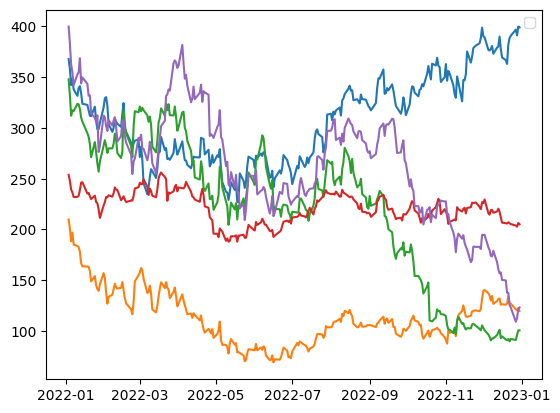

In [110]:
df_now = yf.download(['DECK', 'ETSY', 'GNRC', 'RMD', 'TSLA'], start='2022-01-01', end='2023-01-01')

plt.plot(df_now['Adj Close'])
plt.legend()

In [107]:
# check for correlation after auto factorized
import numpy as np
cov = res_df.corr()
for cls in res_dict.values():
    res_df_temp = res_df[cls]
    corr = res_df_temp.corr()
    list_corr = []
    for i in range(len(corr)):
        for j in range(i):
            list_corr.append(corr.iloc[i, j])
    print(np.mean(list_corr))
# delet anything with correlation < 0.15

0.2146777870261069
0.5969672957724629
0.1391714593330671


In [12]:
cov = res_df.corr()
# correlation matrix cleaning
for i in range(len(cov)):
    for j in range(i+1):
        cov.iloc[i, j] = 0
classi = 3
for i in range(3):
    max_value = cov.max().max()  # Get the maximum value across all rows and columns
    max_row, max_col = cov.stack().idxmax()  
    print(max_value, max_row, max_col)

    cov.drop([max_row, max_col], inplace=True)
    cov.drop(columns=[max_row, max_col], inplace=True)

0.799800153916491 AMAT LRCX
0.536247517061427 DXCM PODD
0.304298809043346 DECK ETSY
